In [19]:
from typing import (Tuple, List, Callable)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

import cvxpy as cp
import torch
import torch.nn.functional as F
from cvxpylayers.torch import CvxpyLayer

torch.set_default_dtype(torch.float64)

# Learning a robust Kalman smoother for vehicle tracking

We will try to recover the state history (*i.e.*, location and velocity trajectories) of a moving vehicle from noisy sensor data. To do this, we'll model the vehicle state as a discrete-time linear dynamical system and use standard and robust **Kalman smoothers** to estimate the state history of this system from the noisy sensor measurements. To construct our smoothers, we'll depart from typical Kalman methodologies in favor of an optimization-based approach. Considering these optimization problems as mutable objects, we then take a machine learning approach to evaluating and tuning the smoothers.

# Background

The primary aim of this notebook is demonstrating how to use `cvxpylayers` to auto-tune parameters in a Kalman smoother. That said, it also contains a broad introduction to Kalman smoothing and a somewhat opinionated tutorial on mathematical optimization based Kalman smoothing. If you're a reader who is familiar with Kalman smoothers and/or just want to focus on the auto-tuning problem, that material starts in the **Background/Learning** section. The entire **Implementation** section is then focused on using `cvxpylayers` to auto-tune vehicle tracking Kalman smoothers. 

## Motivating work

We also want to emphasize that this notebook is rather unoriginal. It is an extension of the [robust Kalman filtering for vehicle tracking](https://www.cvxpy.org/examples/applications/robust_kalman.html) example found on the CVXPY website, and it is a watered-down, slight variation of the work in \[[BB20](https://stanford.edu/~boyd/papers/auto_ks.html)\] and in \[[BV18 sec17.2](https://web.stanford.edu/~boyd/vmls/)\]. All three of these sources are **highly recommended** for anyone wanting to learn more about Kalman smoothers and the Kalman smoother auto-tuning problem.

## System Model

We consider a linear, dynamical system (LDS) governed by

$$
\begin{equation}
x_{t+1} = Ax_t + Bw_t, \quad t =1, \ldots, T-1,
\tag{1}
\end{equation}
$$

and output or sensor measurements

$$
\begin{align}
y_t = Cx_t + v_t, \quad t=1, \ldots, T.
\tag{2}
\end{align}
$$

Here $x_t \in \mathbf{R}^{n}$ is the state, $w_t \in \mathbf{R}^{m}$ is an input to the dynamical system (*e.g.*, a drive force on the vehicle), $y_t \in \mathbf{R}^{p}$ is the output or sensor measurement, and $v_t \in \mathbf{R}^{p}$ is the sensor noise, at time $t$. The matrix $A \in \mathbf{R}^{n \times n}$ is the state dynamics matrix, $B ∈ \mathbf{R}^{n \times m}$ is the input matrix, and $C \in \mathbf{R}^{p \times n}$ is the observation (or output) matrix. 

In *state estimation*, **the goal** is to guess the state sequence, $x_1, \ldots, x_T$, using the observations $y_1, \ldots, y_T$. In vehicle tracking, $x_t$ could be a four-vector (*i.e.*, $x_t \in \mathbf{R}^{4}$), where $\left(x_t \right)_{1:2}$ is the position of the vehicle in two dimenions, $\left(x_t \right)_{3:4}$ is the vehicle velocity, and $y_t$ could be a five-vector containing measurements of latitude, longitude, heading, speed, and altitude of an iPhone mounted on the vehicle (this is an example in \[[BB20](https://stanford.edu/~boyd/papers/auto_ks.html)\]).

Traditionally, the matrices $A$, $B$, and $C$ are assumed fixed, while statistical assumptions are placed on $w_1, \ldots , w_{T-1}$ and $v_1, \ldots, v_{T}$. Importantly, whether the lack of knowledge is encoded statistically or not, we do not exactly know these noises. If $w_1, \ldots, w_{T-1}$ and $v_1, \ldots, v_T$ were known to us, we would be *solving for* $x_t$, not *estimating* $x_t$. (Sometimes, when arriving at an estimation, $x_t$ is replaced with $\hat{x}_t$ to clearly mark this distinction.)

## Smoothing

### Overview

Smoothing is an offline (or batch) approach to approximately reconstructing the state sequence, *i.e.*, the measurements $y_1, \ldots, y_T$ are collected, and *then* smoothing is performed to estimate $x_1, \ldots, x_T$. There are many approaches to constructing smoothers. The most widely used approach is an extension of **Kalman filtering**. (See \[[Mur23 sec8.2](https://probml.github.io/pml-book/book2.html)\] for an overview of the classical Kalman filtering and smoothing methodologies based on the original worked proposed in \[[Kal60](https://www.unitedthc.com/DSP/Kalman1960.pdf)\]. But briefly, while smoothing is an offline algorithm used to reconstruct a state trajectory, filtering is an online algorithm used to estimate the current state of the LDS as new measurements arrive. With that being said, the first step in the classical approach to constructing a smoother is to construct a filter.)

In this notebook, however, we consider constructing smoothers by (explicitly) formulating optimization problems. Therefore, we perform the *act* of smoothing, obtaining $\hat{x}_1, \ldots, \hat{x}_T$, by *solving* a smoother's optimization problem. A major advantage to this mathematical optimization approach is the ability to formulate smoothers that handle missing measurements. If a smoother can handle missing measurements, we can take a machine learning approach to evaluating it. That is, to assess how well a smoother *generalizes* to unseen data, we can purposefully withhold measurements when creating the smoother and then compare the smoother's predicted outputs with this unseen (test) data. Additionally, because smoothers are characterized (or flavored) by parameters (hyper-parameters, in machine learning dialect), comparing the *prediction error* between smoothers is one way of determining whether one smoother is "better" than another.

There are also a couple, less technically deep, advantages to this mathematical optimization approach to smoothing. Firstly, smoothers formulated as optimization problems are incredibly easy to interpret. In fact, the idea of a smoother "object" only arises in an optimization context. In typical literature, Kalman filtering (recalling that smoothing is filtering with some additional adjustments) is just a clever method for computing estimates of the LDS state and state uncertainty recursively. Consequently, understanding what a Kalman filter does in a traditional sense requires understanding some ideas from probability and statistics which are not usually seen in first courses on the subjects. In comparison, even if we were to incorporate statistical assumptions into our optimization models, such as those considered in \[[BB20](https://stanford.edu/~boyd/papers/auto_ks.html)\], a smoother packaged as an optimization problem can just be "read off" as a state estimator.

It also is far easier to extend and solve smoothers in a (convex) optimization approach than in a statistical approach. For instance, in the sequel, we'll construct a robust smoother by swapping quadratic penalty terms in the non-robust smoother's optimization problem's objective function with Huber penalty terms. This replacement is obvious to anyone familiar with convex optimization (particularly the ideas in \[[BV04 ch6](https://stanford.edu/~boyd/cvxbook/)\]), and because the resulting problem is convex, it is readily solved. However, making such a swap in the traditional statisical approach would be less trivial.

Using an out-of-the-box Kalman filter or smoother is certainly not difficult. Because the update equations which define a filter/smoother are already derived, Kalman filtering/smoothing in practice is simply an exercise in sparse linear algebra. However, because the traditional filter is constructed as a mean squared error minimizer (or through maximum likelihood statistics), adjusting the filter to be more robust would require re-constructing the filter to be the minimizer of the expectation of some other error function. Considering the effort required to derive the typical Kalman filter, this approach is not too appealing. This work would only be further complicated if the typical Gaussian assumptions were replaced with fatter-tailed distributions (an idea proposed in \[[BB20](https://stanford.edu/~boyd/papers/auto_ks.html)\]). However, if we were to add statistical assumptions to our approach, such a distribution swap would be trivial so long as it maintained problem convexity. We could even add probabilistic restrictions or desired attributes to the filter/smoother via problem constraints.

All of this is to say that an optimization approach to smoothing is **declarative.** Put glibly, you hand some observed measurements to a smoother problem and say (through a `.solve()` call) "find a state sequence that is consistent with these measurements and some *a priori* knowledge of the system dynamics." The solver will then return to you (assuming feasibility) **the best possible state sequence matching the smoother's requirements**, and it will do so reliably and efficiently. (The idea of optimization being a declarative manner of solving problems is explored [here](https://www.youtube.com/watch?v=EwYgjTAagXQ&t=1370s) in the context of control.)

Before detailing our optimization approach, it is worth noting that the typical Kalman filter and smoother are still terrific approaches to state estimation. The traditional approach to Kalman *filtering* actually has a major advantage over this optimization approach: once a state estimate is computed, all observations can be thrown away. Therefore, it's less memory intensive than an optimization approach, and thus more desirable in an online setting (one might argue that an optimization approach is also too computationally expensive in an online setting, but this is a non-issue. See \[[01 p4](https://web.stanford.edu/~boyd/papers/learning_cocps.html)\]).

### Approach

We'll consider the main problem formulation ideas here. The conclusion of these ideas will be a basic smoother problem, but the optimization problems used to construct the smoothers that we'll consider in the vehicle tracking example will be stated later in this notebook.

Looking again at (1) and (2), the components of our optimization problem arise quite naturally. Because we are trying to determine the state sequence $x_1, \ldots, x_T$, these are optimization variables; they need to be decided upon. However, these variables are subject to the requirement that they satisfy the dynamic system model (1), so

$$
x_{t+1} = Ax_t + Bw_t, \quad t =1, \ldots, T-1,
$$

must be constraints in the formulation.

A fundamental assumption in Kalman filtering and smoothing is that the input and output noises are not too large. Or, to rely on (basic) statistics just briefly, *that the means of both the input noise and measurement noise are known.* This assumption can be understood intuitively thinking through what a Kalman smoother (or filter) is doing. 

We are *assuming* that we have two sources of (informally) information about the state in some system of interest. The first is the mathematical model, (1), which dictates how the state should evolve in time. The second is sensor measurements of the state as it does evolve in time. However, both sources include some form of randomness. The purpose of the Kalman smoother (or filter) is to merge these two somewhat reliable state estimators into a far more reliable state estimator. Furthermore, if $w_t$ is not small (or rather, if $w_t$ less the mean input noise is not small), then the first source of information becomes unreliable. Likewise, if the sensor noise is not "small" (there's no structure to its randomness), then there's no reason to believe that the measurements $y_t$ provide any useful information about the state.

This fundamental assumption leads us to a bi-criterion optimization problem where we wish to minimize both the sensor noise (or equivalently, the size of the discrepancy between sensor measurements and predicted outputs) and the input noise. Mathematically, a good (and pervasive across Kalman smoothing/filtering) characterization of the total sensor noise is the sum of squares of the norms of the measurement residuals,

$$
J_{\text{meas}} = \left\lVert v_1 \right\rVert_{2}^2 + \cdots + \left\lVert v_T \right\rVert_{2}^2 = \left\lVert Cx_1 - y_1 \right\rVert_{2}^2 + \cdots + \left\lVert Cx_T - y_T \right\rVert_{2}^2.
$$

Likewise, we'll take the total process noise to be the sum of squares of the norms of the process noise,

$$
J_{\text{proc}} = \left\lVert w_1 \right\rVert_{2}^2 + \cdots + \left\lVert w_T \right\rVert_{2}^2.
$$ 

Combining this bi-criterion objective with the aforementioned constraints leads us to the simple smoother formulation

$$
\begin{equation}
\begin{array}{lll}
\text{minimize} \; & \tau J_{\text{proc}} + J_{\text{meas}} & \\
\text{subject to} & x_{t+1} = Ax_t + Bw_t, \; & t=1, \ldots, T-1,
\end{array}
\tag{3}
\end{equation}
$$

where $x_t \in \mathbf{R}^{n}$ and $w_t \in \mathbf{R}^{m}, \, t=1, \ldots, T,$ are optimization variables and $\tau > 0$ is a **tuning parameter** in the problem which (roughly) determines whether we trust the measurements more, or the dynamics more. (Throughout this notebook, we'll refer to parameters in a smoother's defining optimization problem as the "smoother's parameters." We'll also refer to a smoother as it's defining optimization problem, *e.g.*, "consider the smoother (3).") 

Clearly, the choice of $\tau$ can drastically affect the estimated state that the smoother produces. The focus of this notebook is demonstrating **how to use `cvxpylayers` to auto-tune smoother parameters** to construct "good" smoothers.

## Missing Measurements 

As the LDS evolves, all updates we have about the system come from the sequence $y_1, \ldots, y_T$. However, it may be the case that the full output sequence is not available to us. Or put another way, the output sequence could have missing measurements (*e.g.*, over a $T=10$ horizon where $y_t \in \mathbf{R}^{2}$, perhaps at the second time step we are missing measurement one, and then at the ninth time step we are missing measurement two). To model this, we modify the output equation (2) so that $y_t \in (\mathbf{R} ∪ \left\{ ? \right\})^p$, where ? denotes a missing value. So (2) becomes

$$
(y_t)_i = (Cx_t + v_t)_i, \quad (t, i) \in \mathcal{K},
$$

where $\mathcal{K} \subseteq \left\{ 1, \ldots, T \right\} \times \left\{ 1, \ldots, p \right\}$ is the set of (scalar) outputs that are available. For $(t, i) \not \in \mathcal{K}$, we take $(y_t)_i = \,?$. We refer to the real entries of $y_t$ as *known measurements* and the entries of $y_t$ that have the value $?$ as *missing measurements.*

**Importantly**, for the remainder of this notebook, we assume that the full output sequence, $y_1, \ldots, y_T$, is collected. That is, $\mathcal{K} = \left\{ 1, \ldots, T \right\} \times \left\{ 1, \ldots, p \right\}$. Nonetheless, we'll need the machinery presented here when we separate the measurements into training and testing datasets (or cross-validation folds), masking measurements $\mathcal{M} \subset \mathcal{K}$ and constructing smoothers with $\mathcal{K} \setminus \mathcal{M}$.

## The smoothing problems

### Initial formulations

Consider again the first proposed smoother, (3). Making the typical statistical assumptions about the noises $w_1, \ldots, w_T$ and $v_1, \ldots, v_T$ and considering the problem as $T → ∞$, it turns out that (3) characterizes the Kalman filter. Or rather, the optimal solution to (3) is the recursive, closed-form update equations that appear in Kalman filtering. This observation is useful because it gives insight into a potential failure of this smoother. Namely, it performs well when $w_t$ and $v_t$ are Gaussian, but large outliers in the measurements will significantly influence the smoother's quadratic objective, thus degrading the accuracy of the smoother's state recovery.

To improve estimation in the presence of outliers, we propose a **robust Kalman smoother,** which is formulated by simply replacing

$$
J_{\text{meas}} = \left\lVert Cx_1 - y_1 \right\rVert_{2} + \cdots + \left\lVert Cx_T - y_T \right\rVert_{2}^2
$$

in (3) with

$$
J_{\text{meas}} = \phi_{\rho}\left(Cx_1 - y_1 \right) + \cdots + \phi_{\rho}\left(Cx_T - y_T \right),
$$

where 

$ϕ_{ρ}: \mathbf{R}^{n} \to \mathbf{R}$, defined as

$$
\phi_{\rho}(u) = \begin{cases}
\left\lVert u \right\rVert_{2}^2 & \left\lVert u \right\rVert_{2} \le \rho \\
\rho(2 \left\lVert u \right\rVert_{2} - \rho) & \left\lVert u \right\rVert_{2} > ρ,
\end{cases}
$$

is the Huber penalty function. This function is "robust" as it penalizes estimation errors linearly outside of a ball of radius $ρ$. Consequently, large measurement outliers will only (roughly) influence the objective function linearly. (See \[[BV04 p298-300](https://stanford.edu/~boyd/cvxbook/)\] for intuition-building visualizations of the Huber function and the induced residual behavior.)

Making this measurement error term replacement (and dropping the $J\text{s}$ for clarity), the robust smoother problem is

$$
\begin{equation}
\begin{array}{lll}
\text{minimize} \; & \sum_{t=1}^{T} \left(\tau \left\lVert w_t \right\rVert_{2}^2 + \phi_{\rho}(Cx_t - y_t) \right) & \\
\text{subject to} & x_{t+1} = Ax_t + Bw_t, \; & t = 1, \ldots, T-1,
\end{array}
\tag{4}
\end{equation}
$$

where again $x_t$ and $w_t, \, t=1, \ldots, T$, are optimization variables, but now both $\tau >0$ and $\rho>0$ are tuning parameters. Specifically, $\tau$ still is a measure of whether we trust the dynamics or the observations more, while $\rho$ (roughly) determines the size of the ball we believe reasonable observations should lie in.

### Handling missing measurements

Consider masking some fraction (*e.g.*, 20%) of the measurements, denoted by the set $\mathcal{M} \subset \mathcal{K}$, resulting in a *masked trajectory* $\tilde{y}_1, \ldots, \tilde{y}_T$. That is, we let $(\tilde{y}_t)_i = \, ?$ for $(t, i) \in \mathcal{M}$ and $(\tilde{y}_t)_i = y_i$ for $(t, i) \in \mathcal{K} \setminus \mathcal{M}$.

To construct smoothers with this masked trajectory, *i.e.,* (in ML dialect) smoothers *trained on* the non-masked measurements, (3) and (4) must be reformulated. To do this, we introduce $T$ output optimization variables, $\hat{y}_1, \ldots \hat{y}_T \in \mathbf{R}^{p}$, which take the place of $y_t$ in (3) and (4)'s objective functions, subject to the constraint that the outputs match the non-masked observations, *i.e.*,

$$\left(\hat{y}_t \right)_i = \left(y_t \right)_i, \quad (t, i) \in \mathcal{K} \setminus \mathcal{M}.$$

Let $N=Tp$ and define the vector $z \in \mathbf{R}^{N}$ as $z = (\hat{y}_1, \ldots, \hat{y}_T)$. Using $z$, (3) and (4) become

$$
\begin{equation}
\begin{array}{lll}
\text{minimize} \; & \sum_{t=1}^{T} \left(\tau \left\lVert w_t \right\rVert_{2}^2 + \left\lVert Cx_t - \hat{y}_t \right\rVert_{2}^{2} \right) & \\
\text{subject to} & x_{t+1} = Ax_t + Bw_t, \; & t = 1, \ldots, T-1 \\
& S z = c & 
\end{array}
\tag{5}
\end{equation}
$$

and

$$
\begin{equation}
\begin{array}{lll}
\text{minimize} \; & \sum_{t=1}^{T} \left(\tau \left\lVert w_t \right\rVert_{2}^2 + \phi_{\rho}(Cx_t - \hat{y}_t) \right) & \\
\text{subject to} & x_{t+1} = Ax_t + Bw_t, \; & t = 1, \ldots, T-1 \\
& S z = c, & 
\end{array}
\tag{6}
\end{equation}
$$

where $S \in \mathbf{R}^{ \left| \mathcal{K} ∖ \mathcal{M} \right| \times N}$ is a selector matrix and $c ∈ \mathbf{R}^{\left| \mathcal{K} \setminus \mathcal{M} \right|}$ contains the corresponding entries of $y_t$. Concretely, if we denote the elements in $\mathcal{K} ∖ \mathcal{M}$ as $\left(\mathcal{K} ∖ \mathcal{M} \right)_1, \ldots, \left(\mathcal{K} ∖ \mathcal{M} \right)_{\left| \mathcal{K} ∖ \mathcal{M} \right|}$, then if $\left(\mathcal{K} ∖ \mathcal{M} \right)_j = (t, i)$, the $j\text{th}$ row of $S$ is $e_{tp + i}$ and the $j\text{th}$ entry of $c$ is $(y_t)_i$.

### Solving the Kalman smoothing problems

Since we wish to use `cvxpylayers` to learn smoother parameters, our smoothers must be [DPP-compliant](https://www.cvxpy.org/tutorial/dpp/index.html). (It is worth noting that more efficient, non-`cvxpylayer` solutions can be developed by exploiting a particular smoother's problem structure. Again, refer to \[[BB20](https://stanford.edu/~boyd/papers/auto_ks.html)\] for an example of this.)

In the above formulations, (5) can immediately be used to construct a `CvxpyLayer` object. However, (6) is not DPP-compliant. Furthermore, to construct robust smoothers, we reformulate (6) as

$$
\begin{equation}
\begin{array}{lll}
\text{minimize} \; &  h    & \\
\text{subject to} & \tau\left( \sum_{t=1}^{T} \left\lVert w_t \right\rVert_{2}^2 \right)  +
\left( \sum_{t=1}^{T}  u_t^2 + 2\rho q_t \right) \le h & \\
& \left\lVert Cx_t - \hat{y}_t \right\rVert_{2} \le u_t + q_t & t=1, \ldots, T \\
& 0 \preceq u \preceq \rho \mathbf{1} & \\
& q \succeq 0 & \\
& x_{t+1} = Ax_t + Bw_t, & t = 1, \ldots, T-1 \\
& S z = c, 
\end{array}
\tag{7}
\end{equation}
$$

where $u, q \in \mathbf{R}^{T}$ and $h \in \mathbf{R}$ are auxilary optimization variables. The equivalence of (6) and (7) is based on a result shown in the appendix (bottom of the notebook). To see the reformulation (roughly, and implicitly using (6) & (7)'s, not (A2)'s symbols), simply separate the summand in the objective function of (6), replace the summation of Huber penalties with the objective function in (A2), and then append (A2)'s constraints to this new problem. Because (A2) is shown equivalent to (A1) by fixing the $x_t$ variables, the constraints in (6) and total process noise term in (6)'s objective function can be ignored when reformulating the Huber measurement penalties since fixing $x_t$ decouples $\hat{y}_t$ and $w_t$.

Finally, (7) is obtained by placing this transformed problem into epigraph form. This last step is not required for DPP-compliance, but if it is **not** done, `diffcp` is unable to differentiate through the problem.


## Evaluating a Kalman smoother

The first step in judging a Kalman smoother is to mask some fraction (*e.g.*, 10% or 20%) of the observations, denoted by the set $\mathcal{M} ⊂ \left\{1, \ldots, T \right\} \times \left\{ 1, \ldots, p \right\}$. We then use the known set $\mathcal{K} ∖ \mathcal{M}$ to construct the selector matrix $S$ and the non-masked observation vector $c$. 

We then solve that smoother problem with $S$ and $c$, resulting in a predicted output trajectory $\hat{y}_1, \ldots \hat{y}_T$.

To judge the Kalman smoother, we calculate the *prediction error*, which we'll take to be the mean squared difference between the predicted output trajectory and the actual trajectory in the entries that we masked,

$$
\begin{equation}
L(\theta) = \frac{1}{\left| \mathcal{M} \right|} ∑_{(t, i) \in \mathcal{M}} \left( \left( \hat{y}_t \right)_i - \left( y_t \right)_i \right)^2. 
\tag{8}
\end{equation}
$$

We'll refer to this prediction error as the mean squared error (MSE) of this smoother (*i.e.* the smoother trained on $\mathcal{K} ∖ \mathcal{M}$ parameterized by $\theta$). Importantly, because a smoother's predicted output trajectory is a function of the smoother's parameters, the prediction error $L$ is also a function of the parameters.

The goal in the sequel will be to adjust the parameters to minimize this error.

## Learning 

In this section we consider the Kalman smoother automatic parameter-tuning problem. We then present how to use `cvxpylayers` to solve this auto-tuning problem for (5) and (7), as well as the use of cross-validation to assess the generalizability of the tuned smoothers.

Before moving forward however, **a disclaimer.** This is an **explanatory notebook.** Consequently, barely any effort was spent considering how to *solve* the parameter-tuning problem (or equivalently, the `tune_kalman_smoother` function). This is for a reader to consider in the context of their own smoother problem.


### Auto-tuning (learning) problem

To tune a Kalman smoother parameterized by $\theta$, we wish to minimize the prediction error, $L(\theta)$, on some held out measurements, $\mathcal{M}$. That is, we wish to solve the problem

$$
\text{minimize} \quad L(\theta),
$$

with the variable $\theta$. **This is actually a difficult problem** since $L$ is not necessarily convex (and almost certainly isn't) and while the problem appears unconstrained, there are *implicit* problem constraints.

Specifically, define $\Theta$ to be the set of parameters that the smoother optimization problem is defined for (*e.g.*, (7) is parameterized by $\theta = (\tau, \rho) ∈ \mathbf{R} × \mathbf{R}$ but only defined for $\Theta = \mathbf{R}_{++} \times \mathbf{R}_{++}$). Since evaluating the prediction loss at some point $\theta$ implicitly requires solving a smoother problem parameterized by $\theta$, the prediction error function is only defined for $\theta \in \Theta$. Concretely, $\textbf{dom} \, L = \Theta$. Furthermore, $\theta \in \Theta$ is an *implicit constraint* in the above optimization problem (equivalently, the *problem's domain* is $\Theta$). 

The arising complication is that $\textbf{dom} \, L = \Theta$ **does not** constrain $\theta \in \Theta$. Because $L$ does not have a natural extended-value extension (convexity would be a sufficient condition for defining such an extension), $\theta \to \textbf{bd}\,\Theta$ does not imply that $L \to \infty$, so iterative optimization algorithms can converge to $\theta \not \in \Theta$. This is problematic as evaluating $L$ with an invalid parameter will result in a `.solve()` call to an optimization problem which has "been told" will only need to solve problems for $\theta \in \Theta$. The iterative method finding a locally optimal $\theta$ will then terminate prematurely with a nasty error message from the smoother problem.

To address this issue, we propose 

$$
\begin{equation}
\text{minimize} \quad F(\theta) = L(\theta) + r(\theta)
\tag{9}
\end{equation}
$$

with variable $\theta$ as the **Kalman smoother auto-tuning problem**, where $r$ is a regularization function such that $\textbf{dom} \, r = \Theta$ and $r(\theta) = +\infty$ for $\theta \not \in \Theta$. 

Note that $\Theta$ can also include constraints on what parameters are allowed to change or constraints on what parameters are desirable. Making these restrictions adds more nuance to the above solver-error-throw argument, but the formulation of (9) does not change. 


### Solving the auto-tuning problem for non-robust and robust smoothing 

The process of using `cvxpylayers` to construct Kalman smoothers and auto-tune their parameters simply requires:
1. Formulating the smoother problems with `cvxpy`.
2. Using these smoother objects to construct `CvxpyLayer` objects.
3. Defining a regularization function for each smoother to concretely define $F(\theta)$.
3. Constructing a `tune_kalman_smoother` function to solve (9) using whatever underlying framework was chosen when the layer was constructed (*i.e.*, PyTorch, TensorFlow, or JAX).

Most of this notebook was concerned with (1) and (2), and (4) (as mentioned at the beginning of this **Background/Learning** section) is beyond the scope of this notebook (or rather, best considered for specific, non-toy smoothers). Furthermore, we just consider (3). 

The non-robust Kalman smoother, (5), has one parameter, which we denote by $\theta = \tau \in \mathbf{R}$. The robust smoother, (7), has two parameters, which we denote by $\theta = \left(\tau, \rho \right) \in \mathbf{R} \times \mathbf{R}$.  Both smoothers have the allowable set

$$
\Theta = \left\{ \theta \in \mathbf{R}^{k} \mid \theta \succ 0 \right\},
$$

where $k=1$ and $k=2$, respectively. (Note that for our parameter/allowable parameter notation we're adopting the function notation style found in \[[BV04](https://stanford.edu/~boyd/cvxbook/)\], where a function may be declared over some space, but only defined for a subset of that space.) While there are many possible regularization functions we could choose to define (9), we'll auto-tune our smoothers using the logarithmic barrier function. That is, we'll define

$$
r(\theta) = ∑_{i=1}^{k} - \log θ_i.
$$

### Judging tuned smoothers

#### Update to out-of-sample notation

Once a $\theta$ is obtained via auto-tuning (*i.e.*, once a smoother is tuned), the prediction loss (8) is no longer a valid measurement of that smoother's performance. To evaluate this tuned smoother, we need to test it on another (unseen) output sequence. To reserve a final output prediction error test dataset, we still mask some fraction of the measurements (now more likely 20% than 10%) and then split that mask (rougly) in half to obtain $\mathcal{M} \subset \mathcal{K}$ and $\mathcal{T} ⊂ \mathcal{K}$ such that $\mathcal{M} ∩ \mathcal{T} = ∅$. The Kalman smoother is then formulated (or "trained") on $\mathcal{K} ∖ \left( \mathcal{M} ∪ \mathcal{T} \right)$, tuned on $\mathcal{M}$, and tested on $\mathcal{T}$. (The selector matrix, measurement vector, etc. are all updated accordingly.)

#### Cross-validation

We perform $\mathcal{N}\text{-fold}$ cross-validation by dividing $\mathcal{K}$ into $\mathcal{N}$ sets (folds), and then constructing $\mathcal{N}$ smoothers on $\mathcal{N}-1$ folds, using half of the measurements of the withheld fold to tune the smoother's parameters and the other half to evaluate the performance of the smoother. Concretely, we generate

$$
\mathcal{M}_n ⊂ \mathcal{K} \quad \text{and} \quad \mathcal{T}_n ⊂ \mathcal{K}, \quad \mathcal{M}_n ∩ \mathcal{T}_n = ∅, \quad n =1, \ldots \mathcal{N},
$$

where for each $n$

$$
\left| \mathcal{M}_n \right| + \left| \mathcal{T}_n \right| ≈ \frac{1}{\mathcal{N}} \left| \mathcal{K} \right|.
$$

Without loss of generality, we construct the first of our $\mathcal{N}$ smoothers with $\mathcal{K} ∖ (\mathcal{M}_\mathcal{N} ∪ \mathcal{T}_{\mathcal{N}})$, use $\mathcal{M}_\mathcal{N}$ to tune the smoother's parameters, and $\mathcal{T}_{\mathcal{N}}$ to compute the smoother's mean squared prediction error.

# Implementation (vehicle tracking example)

We consider the vehicle tracking example stated above, where $x_t \in \mathbf{R}^{4}$ contains the vehicle's 

## Plotting helper functions

In [5]:
def plot_state(t, actual, estimated=None):
    '''
    plot position, speed, and input in the x and y coordinates for
    the actual data, and optionally for the estimated data
    '''
    trajectories = [actual]
    labels = ['Actual']
    colors = ['#1f77b4']

    if estimated is not None:
        trajectories.append(estimated)
        labels.append('Estimated')
        colors.append('red')

    fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(12,8))
    
    for idx, (data, label) in enumerate(zip(trajectories, labels)):
        x, w = data
        ax[0,0].plot(t, x[0,:-1], color=colors[idx], label=label)
        ax[0,1].plot(t, x[1,:-1], color=colors[idx])
        ax[1,0].plot(t, x[2,:-1], color=colors[idx])
        ax[1,1].plot(t, x[3,:-1], color=colors[idx])
        ax[2,0].plot(t, w[0,:], color=colors[idx])
        ax[2,1].plot(t, w[1,:], color=colors[idx])

    ax[0,0].set_ylabel('$x$ position')
    ax[1,0].set_ylabel('$x$ velocity')
    ax[2,0].set_ylabel('$x$ input')

    ax[0,1].set_ylabel('$y$ position')
    ax[1,1].set_ylabel('$y$ velocity')
    ax[2,1].set_ylabel('$y$ input')

    ax[0,1].yaxis.tick_right()
    ax[1,1].yaxis.tick_right()
    ax[2,1].yaxis.tick_right()

    ax[0,1].yaxis.set_label_position("right")
    ax[1,1].yaxis.set_label_position("right")
    ax[2,1].yaxis.set_label_position("right")

    ax[2,0].set_xlabel('$t$')
    ax[2,1].set_xlabel('$t$')

    # Add a single legend
    fig.legend(labels, loc='upper right', ncol=2)


def plot_positions(traj: List[List[np.ndarray]],
                   titles: List[str],
                   legends: List[List[str]],
                   plot_args: List[List[str]],
                   axis=None,
                   filename=None):
    matplotlib.rcParams.update({'font.size': 14})
    n = len(traj)
    
    assert len(traj) == len(titles) == len(legends) == len(plot_args), "Input lists must have the same length."

    rows = int(np.ceil(n / 2))
    cols = 2 if n > 1 else 1
    
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(12, 5 * rows))
    
    # Ensure ax is a 2D array
    if rows == 1:
        ax = np.array([ax])
    if cols == 1:
        ax = ax.reshape(-1, 1)
    
    ax = ax.flatten()
    
    for i, xs in enumerate(traj):
        for j, x in enumerate(xs):
            typ = plot_args[i][j]
            alpha = 0.1 if 'o' in typ else 1
            ax[i].plot(x[0, :], x[1, :], typ, alpha=alpha)
        ax[i].set_title(titles[i])
        ax[i].legend(legends[i], loc='upper right')
        if axis:
            ax[i].axis(axis)
    
    # Hide unused subplots if n is odd
    for j in range(n, rows * cols):
        fig.delaxes(ax[j])
    
    plt.tight_layout()
    
    if filename:
        fig.savefig(filename, bbox_inches='tight')


## Problem dynamics
The matrices for the system dynamics (and output) are
$$
A = \begin{bmatrix}
1 & 0 & (1- \frac{\gamma}{2}\Delta t) & 0 \\
0 & 1 & 0 & (1- \frac{\gamma}{2}\Delta t) \\
0 & 0 & 1 - \gamma \Delta t & 0 \\
0 & 0 & 0 & 1 - \gamma \Delta t
\end{bmatrix},
$$

$$
B = \begin{bmatrix}
\frac{1}{2}\Delta t^2 & 0 \\
0 & \frac{1}{2}\Delta t^2 \\
\Delta t & 0 \\
0 & \Delta t,
\end{bmatrix}
$$
and
$$
C = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix},
$$
where $\gamma$ is a velocity damping parameter.

In [3]:
n = 4 # number of entries in the state vector
m = 2 # number of entries in the input vector
p = 2 # number of entries in the measurement vector
gamma = 0.05 # velocity damping; 0 is no damping

num_steps = 1000
T = num_steps
end_time = 50 # time will move from 0 to end_time with step delt
times, delt = np.linspace(0, end_time, num_steps, endpoint=True, retstep=True)
N = T*p # number of total possible measurements

A = np.zeros((n, n))
B = np.zeros((n, m))
C = np.zeros((p, n))

# Dynamics for this particular problem
A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

C[0,0] = 1
C[1,1] = 1

C_tch = torch.tensor(C) # used in loss functions

## Generating trajectories

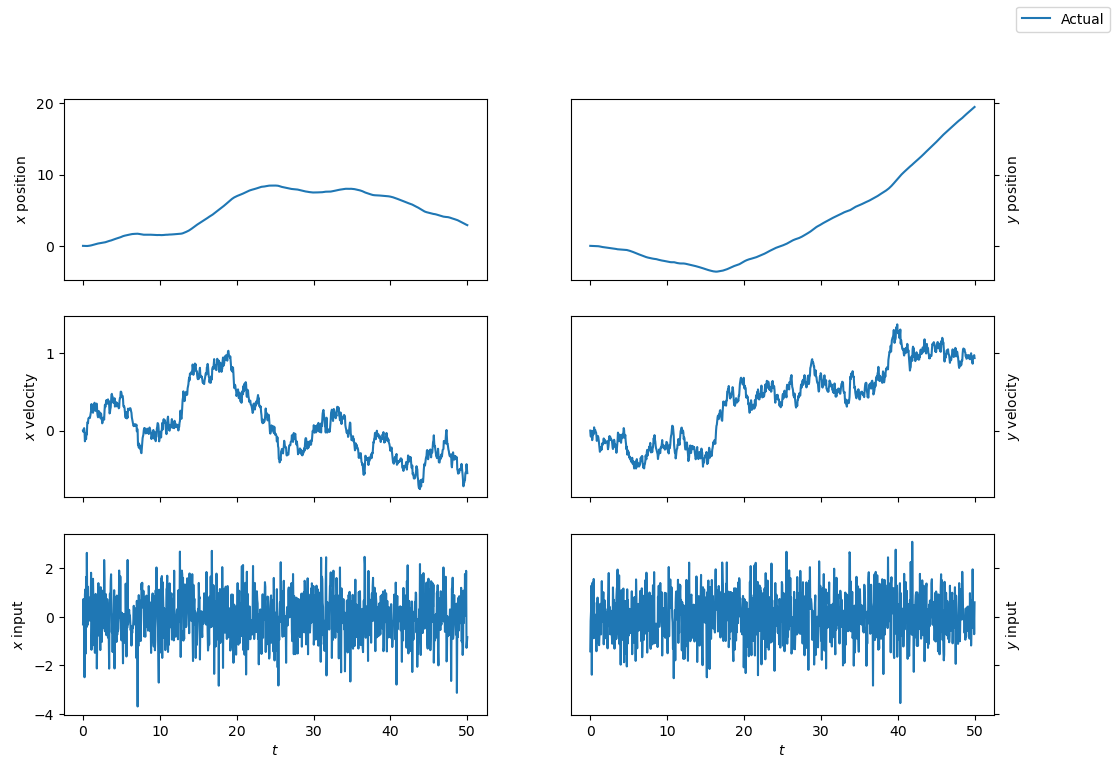

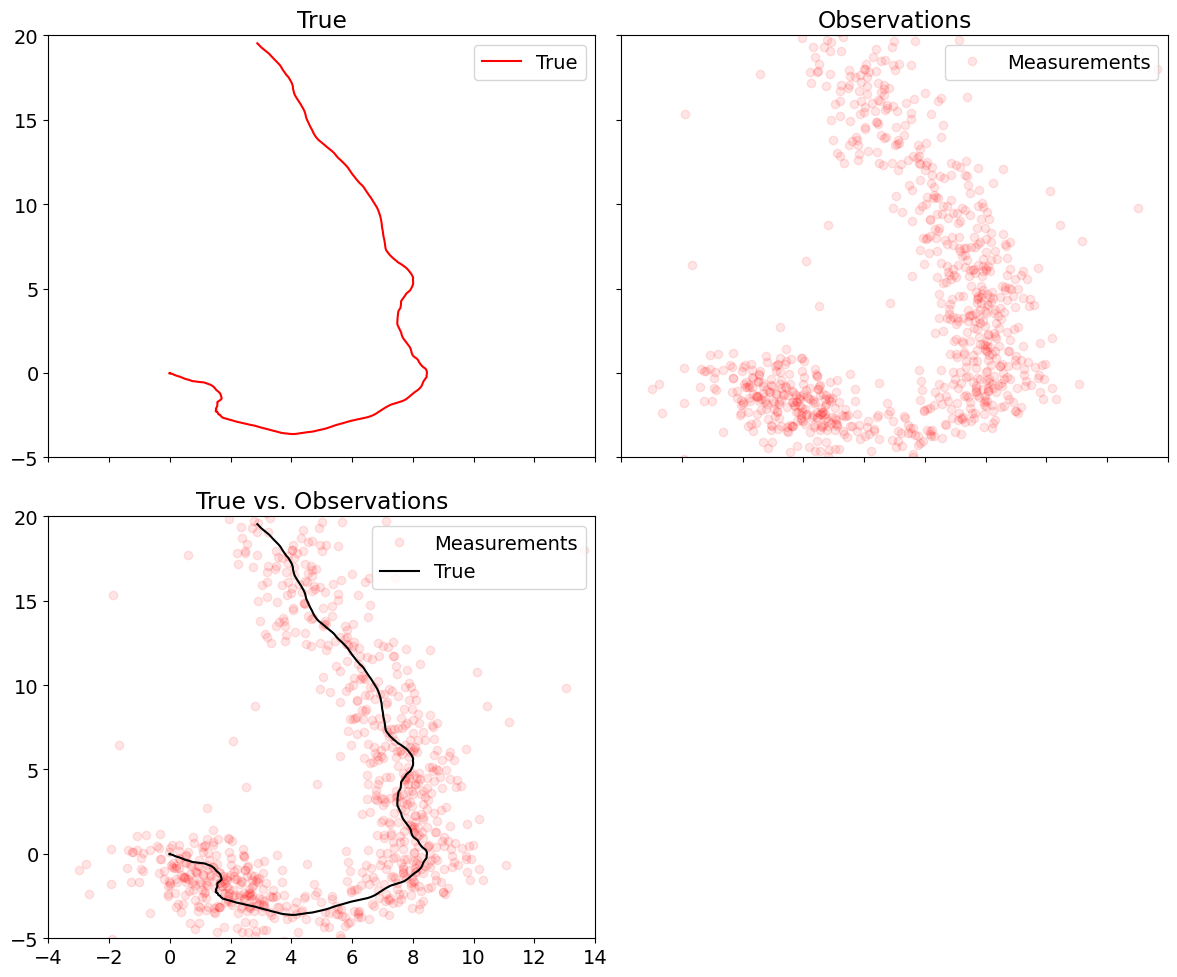

In [6]:
sigma = 20
num_outliers = .20

x = np.zeros((n,T+1))
x[:,0] = [0,0,0,0]
y = np.zeros((p,T))

# generate random input and noise vectors
np.random.seed(6)
w = np.random.randn(m,T)
v = np.random.randn(p,T)

# add outliers to v
np.random.seed(0)
inds = np.random.rand(T) <= num_outliers
v[:,inds] = sigma*np.random.randn(p, T)[:,inds]

# simulate the system forward in time
for t in range(T):
    x[:, t+1] = A@x[:, t] + B@w[:, t]
    y[:, t] = C@x[:, t] + v[:, t]

x_true = x.copy()
w_true = w.copy()

plot_state(times,(x_true,w_true))
plot_positions(traj=[[x_true], [y], [y, x_true]],
               titles=['True',
                       'Observations',
                       'True vs. Observations'],
                legends=[['True'],
                         ['Measurements'],
                         ['Measurements', 'True']],
                plot_args=[['r'],
                           ['ro'],
                           ['ro', 'k']],
                axis=[-4,14,-5,20])

## Smoother Instantiation

Creating the cvxpylayers 

In [7]:
def create_kalman_smoother(S: sparse.csc_matrix, c: np.ndarray) -> CvxpyLayer:    
    """Construct a standard Kalman smoother with measurements K setminus M_n.

    Args:
        - S: |K setminus M_n| x N selection matrix.
        - c: |K setminus M_n|-vector of measurements.

    Returns:
        - A CvxpyLayer which solves a (or a batch of) standard Kalman
        smoothing problem(s) upon receiving a (or a batch of) tuning
        parameter(s), tau.
    """
    x = cp.Variable(shape=(n, T+1))
    w = cp.Variable(shape=(m, T))
    # Missing data constraints
    y_hat = cp.Variable(shape=(p, T))
    z = cp.vec(y_hat, order='F')
    
    tau = cp.Parameter(pos=True)

    f0 = tau*cp.sum_squares(w) + cp.sum_squares((C@x)[:, :T] - y_hat)
    obj = cp.Minimize(f0)

    constr = [ x[:, t+1] == A@x[:, t] + B@w[:, t] for t in range(T) ]    
    constr += [ S@z == c ] # missing data constraint

    problem = cp.Problem(obj, constr)

    layer = CvxpyLayer(
            problem,
            parameters=[tau],
            variables=[x, y_hat, w]
        )
    return layer


def create_robust_kalman_smoother(S: sparse.csc_matrix, c: np.ndarray) -> CvxpyLayer:
    """Construct a robust Kalman smoother with measurements K setminus M_n.
    
    Args:
        - S: |K setminus M_n| x N selection matrix.
        - c: |K setminus M_n|-vector of measurements.

    Returns:
        - A CvxpyLayer which solves a (or a batch of) robust Kalman
        smoothing problem(s) upon receiving a (or a batch of) tuning
        parameter(s), tau and rho.
    """
    x = cp.Variable(shape=(n, T+1))
    w = cp.Variable(shape=(m, T))
    h = cp.Variable()
    # Missing data constraints 
    y_hat = cp.Variable(shape=(p, T))
    z = cp.vec(y, order='F')
    # Huber auxilary variables
    u = cp.Variable(T) 
    q = cp.Variable(T)  

    tau = cp.Parameter(pos=True) 
    rho = cp.Parameter(pos=True)

    f0 = tau*cp.sum_squares(w)
    f0 += cp.sum([ cp.square(u[t]) + 2*rho*q[t] for t in range(T)])
    constr = [f0 <= h]
    obj = cp.Minimize(h)

    # Huber constraints
    constr += [cp.norm(C@x[:, t] - y_hat[:, t], 2) <= u[t] + q[t] for t in range(T)]
    constr += [u[t] <= rho for t in range(T) ]
    constr += [0 <= u, 0 <= q]

    # smoother constraints
    constr += [ x[:, t+1] == A@x[:, t] + B@w[:, t] for t in range(T) ]
    constr += [ S@z == c ] # missing data constraint
    
    problem = cp.Problem(obj, constr)
    layer = CvxpyLayer(
        problem,
        parameters=[tau, rho],
        variables=[x, y_hat, w]
    )
    return layer

## Learning (Auto-Tuning) Functionality

### Data separation functions

Mention difference between $(\mathcal{K} \setminus \mathcal{M})_i$ mathematically and in the code.

Mathematically use cardinality

In code $\left| \mathcal{K} \setminus \mathcal{M}_i \right|$ is found by summing all nonzero entries.

In [8]:
def split_data(fraction: float=0.9) -> Tuple[int, np.ndarray]:
    """Split data into a training set and a test set.
    
    Args:
        - fraction: Fraction of the measurement dataset
            included in the training dataset.
    
    Returns:
        - The number of measurements in the training set.
        - A T x p mask matrix. The true entries in the matrix
            are the indices of the measurements in the
            training dataset.
    """
    # SEED!
    num_train_pts = int( N*fraction )
    K_setminus_M = np.zeros(N, dtype=int)
    K_setminus_M[:num_train_pts] = 1
    np.random.shuffle(K_setminus_M)
    K_setminus_M = K_setminus_M.astype(bool).reshape((T, p))
    return num_train_pts, K_setminus_M

In [9]:
def cv_split(num_folds: int=10) -> List[Tuple[int, np.ndarray, np.ndarray]]:
    """Split data into folds for cross-validation.

    Args:
        - num_folds (optional): The number of folds desired for cross-validation.
            Default number of folds is 10.

    Returns:
        - a list such that len(list) == num_folds, where the ith entry
            is the three-tuple (|K setminus M_n|, M_n, K setminus M_n). Both M_n and
            K setminus M_n are T x p mask matrices, whose true entries
            are the indices of the measurements used for model validation and
            model training for the ith fold, respectively.
    """
    np.random.seed(1) # generate same CV split every time

    indices = np.arange(N)
    np.random.shuffle(indices)

    Ms = np.array_split(indices, num_folds)

    to_return = []

    for i in range(num_folds):
        M: np.ndarray = np.zeros(N, dtype=bool)
        M[Ms[i]] = True
        M = M.reshape((T, p))
        K_setminus_M = ~M
        num_train_pts = np.sum(K_setminus_M)
        to_return.append((num_train_pts, M, K_setminus_M))
    
    return to_return

In [10]:
def create_problem_data_params(selected: np.ndarray,
                               num_selected: int=None) -> Tuple[sparse.csc_matrix,
                                                            np.ndarray,
                                                            np.ndarray]:
    """Turns a mask matrix of known measurement indices into the sparse selection matrix
    needed in the standard and robust Kalman smoothing problems.
    
    Args:
        - selected: T x p mask matrix of known measurement indices.
        - num_selected (optional): The number of known measurement
            indices in the selected numpy array.

    Returns:
        - S: num_selected x N sparse selection matrix.
        - c: (num_selected)-vector containing the trajectory
            measurements in the training dataset.
        - c_test: (N - num_selected)-vector containing the trajectory
            measurements not in the training dataset.
    
    """
    num_selected = np.sum(selected) if num_selected == None else num_selected

    time_indices, measurement_indices = selected.nonzero() # think about looping through rows and keeping track if the position is zero or not
    S = sparse.csc_matrix(
        (
            np.ones(num_selected), # data to fill into the sparse array
            (
                np.arange(num_selected),
                time_indices*p + measurement_indices
            )
        ),
        shape=(num_selected, N)
    )
    c = y.T[selected]
    c_test = y.T[~selected]
    return (S, c, c_test)

### Error Functions

In [11]:
def mean_Jmeas_error(y: torch.Tensor, observable_measurements: torch.Tensor,
                layer: CvxpyLayer=None, params: List[torch.Tensor]=None,
                x_hat: torch.Tensor=None, measurement_loss: str='squared') -> torch.Tensor:
    """Prediction error used to judge a Kalman smoother.
    
    Specifically, this function computes
    
        avg (J_meas(theta)) = (1 / np.nonzero(observable_measurments))
                            * sum measurement_loss( ( (C x_hat_t)_i - (y_t)_i ),
    
    where x_hat implicitly depends on theta.

    Used to compute E_train or E_test.

    Args:
        - y: The validation subset of the
            actual trajectory to judge smoother
            output against.
        - observable_measurements: T x p mask matrix
            used to select the predictions from x_hat
            that are to be judged against y.
        - layer (conditonally optional)
        - params (conditonally optional)
        - x_hat (conditonally optional)
        - measurement_loss (optional): Whether to penalize the
            differen

    Returns:
        - A torch.Tensor containing MSE(x_hat - y)
    
    Raises
        - ValueError if either a layer output is not provided
        - ValueError if |K setminus M_n| != |test|

    """

    if (x_hat == None) and (layer == None or params == None):
        raise ValueError("this function requires a layer and parameters\
                         or x_hat = layer(parameters)") 
    
    # can add more checks on x_hat and K setminus M_i

    if x_hat == None:
        x_hat = layer(*params)[1]
    
    y_hat_T = y_hat.t()
    y_hat_to_compare = y_hat_T[observable_measurements]
    return F.mse_loss(y_hat_to_compare, y)

In [12]:
def kalman_recovery_mse(y: torch.Tensor,
                        observable_measurements: torch.Tensor,
                        layer: CvxpyLayer=None,
                        params: List[torch.Tensor]=None,
                        y_hat: torch.Tensor=None) -> torch.Tensor:
    """Prediction error used to judge a Kalman smoother.
    
    Specifically, this function computes
    
        L(theta) = MSE(y_hat - y),
    
    where y_hat implicitly depends on theta.

    Args:
        - y: The validation subset of the
            actual trajectory to judge smoother
            output against.
        - observable_measurements: T x p mask matrix
            used to select the predictions from y_hat
            that are to be judged against y.
        - layer (conditonally optional)
        - params (conditonally optional)
        - y_hat (conditonally optional)

    Returns:
        - A torch.Tensor containing MSE(y_hat - y)
    
    Raises
        - ValueError if either a layer output is not provided
        - ValueError if |K setminus M_n| != |test|

    """

    if (y_hat == None) and (layer == None or params == None):
        raise ValueError("this function requires a layer and parameters\
                         or x_hat = layer(parameters)") 
    
    # can add more checks on y_hat and K setminus M_i

    if y_hat == None:
        y_hat = layer(*params)[1]
    
    y_hat_T = y_hat.t()
    y_hat_to_compare = y_hat_T[observable_measurements]
    return F.mse_loss(y_hat_to_compare, y)

In [13]:
def learning_error_fn(layer: CvxpyLayer, y: torch.Tensor,
                      observable_measurements: torch.Tensor,
                      params: List[torch.Tensor]) -> torch.Tensor:
    """The learning error used to auto-tune a Kalman smoother.

    Specifically, this function computes

        F(theta) = E(theta) + r(theta),

    where L is the loss computed in the `kalman_recovery_mse` function
    (the test error loss) and r is a regularization term added to 
    the prediction loss to encourage the auto-tuning to generate allowable
    hyper-parameters.

    This learning error function assumes that all hyper-parameters must be positive,
    and uses a log-barrier regularization function to encourage positive parameter
    selection. Mathematically,
    
        r(theta) = - sum_i log(theta_i).
    
    Args:
        - layer: The CvxpyLayer being trained.
        - y: The training subset of the
            actual trajectory to judge smoother
            output against. 
        - observable_measurements: T x p mask matrix
            used to select the predictions from y_hat
            that are to be judged against y.
        - params: A list of the (Tensor, require_grad==True)
            hyper-parameters being auto-tuned.

    Returns:
        - A torch.Tensor containing F(theta).
    """
    x_hat = layer(*params)[0]
    y_hat = C_tch@ (x_hat[:, :-1])
    y_hat_T = y_hat.t()
    y_hat_to_compare = y_hat_T[observable_measurements]
    mse_loss = F.mse_loss(y_hat_to_compare, y)
    log_sum = 0.0
    for param in params:
        log_sum -= torch.sum(torch.log(torch.abs(param)))

    return mse_loss + log_sum

### Parameter finding functions

In [11]:
def parameter_sweep(layer: CvxpyLayer,
                    num_params: int) -> Tuple[List[torch.Tensor], torch.Tensor]:
    """
    TODO: ADD!

    The LS and Robust Kalman tuning have 1 and 2 parameters, respectively,
    so the first line will always yield an integer.

    theta_init is a list containing equal length torch Tensors
    such that len(theta_init) == num_params,
    and the ith element element in each tensor 
    """
    steps = 10 // num_params

    logspace_values = [torch.logspace(start=-4, end=7, steps=steps, base=2)
                       for _ in range(num_params)]
    meshgrids = torch.meshgrid(*logspace_values)
    theta_product = torch.stack(meshgrids,
                                dim=-1).reshape(-1,len(logspace_values))
    theta_init = [theta_product[:, i] for i in range(num_params)]
    
    # batch compute solutions
    ys = layer(*theta_init)[1]

    return (theta_init, ys)

In [14]:
def tune_kalman_smoother(train_loss: Callable[[List[torch.Tensor]], torch.Tensor],
                         test_loss: Callable[[List[torch.Tensor]], torch.Tensor],
                         params: List[torch.Tensor],
                         epochs: int=50, lr: float=2e-2,
                         verbose: bool=False,
                         print_every: int=5) -> Tuple[int, float,
                                                      List[List[float]],
                                                      List[float], List[float]]:
    """
    TODO: ADD
    Works for both regular smoother and robust smoother
    
    can mention up above that this is just scaffolding: would go more in depth here for a real problem.
    """

    # opt = torch.optim.Adam(params, lr=lr)
    opt = torch.optim.SGD(params, lr=lr, momentum=0.9)

    best_param_index, best_loss = None, torch.inf
    param_history: List[List[float]] = []
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        
        param_history.append([p.item() for p in params])
        
        with torch.no_grad():
            new_loss = test_loss(params).item()
            if (new_loss < best_loss) and epoch != 0:
                best_loss = new_loss
                best_param_index = epoch
            test_losses.append(new_loss)
        if verbose and epoch % print_every == 0:
            print("test loss %03d | %3.5f" % (epoch + 1, test_losses[-1]))

        opt.zero_grad()
        loss = train_loss(params)
        loss.backward()
        opt.step()
        
        neg_theta = any([p.item() < 0 for p in params])
        if neg_theta:
            break
        
        train_losses.append(loss.item())
        if verbose and epoch % print_every == 0:
            print("train loss %03d | %3.5f" % (epoch+1, train_losses[-1]))
    
    return (best_param_index, best_loss,
            param_history, train_losses, test_losses)
        

### Helper data objects

In [33]:
class AutoTune_DataObject:

    def __init__(self, num_epochs, best_theta_index, best_loss,
                 theta_history, train_losses, test_losses):
        self.tune_succeeded: bool = True if best_theta_index > 0 else False
        self.quit_early: bool = False if len(theta_history) == num_epochs else True
        self.best_theta_index: int = best_theta_index
        self.best_loss: float = best_loss
        self.theta_history: List[List[float]] = theta_history
        self.train_losses: List[float] = train_losses
        self.test_losses: List[float] = test_losses

class Fold_DataObject:
    """

    Contains
        - losses and param values from sweep
        - theta corresponding to lowest test loss

    Can determine if autotune failed by observing size of parameter history list

    Keep track of which tune object contained the best param?

    """
    def __init__(self, num_train_pts, layer):
        self.num_train_pts: int = num_train_pts
        self.layer: CvxpyLayer = layer
        
        self.param_sweep_result = None

        self.auto_tunes = []
        self.theta: List[float] = None
        self.auto_tune_succeeded = False
        self.train_mse = torch.inf
        self.test_mse = torch.inf

    def add_tune_result(self, to_add: AutoTune_DataObject,
                        train_loss: Callable[[List[torch.Tensor]], torch.Tensor]):
        self.auto_tunes.append(to_add)

        best_theta_index = to_add.best_theta_index
        
        if to_add.tune_succeeded:
            self.auto_tune_succeeded = True
        
        if to_add.best_loss < self.test_mse:
            self.test_mse = to_add.best_loss
            # if the first gradient step fails, then we don't have the training loss, so need to compute.
            self.train_mse = to_add.train_history[best_theta_index] if best_theta_index != 0\
                                    else train_loss(to_add.theta_history[0])
            self.theta = to_add.theta_history[best_theta_index]

        

class CV_DataObject:
    """
    Contains
        - number of folds
        - CV-MSE error
        - each fold
    
    TODOS:
        - make sure to serialize/save after running cross_validate

    if size of fold list == num_folds, automatically compute final statistics.
    """
    def __init__(self, num_params, num_folds):
        self.num_params = num_params
        self.num_folds = num_folds
        self.folds: List[Fold_DataObject] = []

        self.mse_cv_error = torch.inf

    def add_fold(self, to_add: Fold_DataObject):
        self.folds.append(to_add)
        
        if len(self.folds) == self.num_folds:
            self.compute_cv_errors()

    def compute_cv_error(self):
        sum_square = 0
        for fold in self.folds:
            sum_square += fold.test_mse**2
        return sum_square / len(self.folds)

### Cross-validation instantiation

In [34]:
def cross_validate(create_smoother: Callable[[sparse.csc_matrix, np.ndarray],
                                             CvxpyLayer],
                   num_params: int,
                   num_folds: int=10,
                   num_st_pts: int=3,
                   num_epochs: int=50,
                   verbose: bool=False,
                   double_verbose: bool=False) -> CV_DataObject:
    
    cv_result: CV_DataObject = CV_DataObject(num_params, num_folds)
    
    data_folds = cv_split(num_folds)
    """
    to think about:
        - how to handle failures?
    """
    for i, fold in enumerate(data_folds):
        if verbose:
            print("=== Starting fold %02d | %02d ===" % (i, num_folds))
        
        # === initialize fold's layer & data ===
        num_pts, M, K_setminus_M = fold

        K_setminus_M_tch, M_tch = torch.tensor(K_setminus_M), torch.tensor(M)
        S, c, c_test = create_problem_data_params(K_setminus_M, num_pts)
        c_tch, c_test_tch = torch.tensor(c), torch.tensor(c_test)
        
        layer = create_smoother(S, c)

        fold_to_add: Fold_DataObject = Fold_DataObject(num_pts, layer)
        
        train_loss = lambda parameters : learning_error_fn(layer,
                                                           c_tch,
                                                           K_setminus_M_tch,
                                                           parameters)
        test_loss = lambda parameters : kalman_recovery_mse(y=c_test_tch,
                                                            observable_measurements=M_tch,
                                                            layer=layer,
                                                            params=parameters)

        # === parameter sweep ===
        if verbose:
            print("starting parameter sweep")
        
        theta_inits, xs = parameter_sweep(layer, num_params)
        sweep_loss = lambda x_val : kalman_recovery_mse(y=c_test_tch,
                                                        observable_measurements=M_tch,
                                                        x_hat = x_val)
        
        #   losses is a list containing tuples of length 2
        #   0th entry in the tuple is the list of tensor parameters
                # ex: if num_params==2, then 
                    # losses[0][0] == [torch.tensor(val1), torch.tensor(val2)] =: theta
        #   1st entry is the test loss of the smoother instantiated with 
                # the parameters in the 0th entry of that tuple.
                # ex: losses[0][1] has test mse loss corresponding
                    # to layer(*losses[0][0])
        losses: List[Tuple[
                        List[torch.Tensor],
                        float
                    ]] = [
                        (
                            [theta_inits[j][i] for j in range(num_params)],
                            sweep_loss(xs[i]).item()
                        )
                        for i in range(xs.shape[0])
                    ]
        losses.sort(key=lambda x: x[1])

        fold_to_add.param_sweep_result = losses
        
        # === auto-tuning ===
        if verbose:
            print("starting auto_tuning")
        
        starting_thetas = [theta for theta, _ in losses[0:num_st_pts]]

        for j, theta_0 in enumerate(starting_thetas):
            if verbose:
                print("auto-tuning starting point %02d | %02d" % (j, num_st_pts))
            
            result = tune_kalman_smoother(train_loss, test_loss,
                                          params=theta_0, epochs=num_epochs,
                                          verbose=double_verbose)
            
            fold_to_add.add_tune_result(AutoTune_DataObject(num_epochs, *result), train_loss)
        
        cv_result.add_fold(fold_to_add)
    
    return cv_result

#### Cross-validation helper functions

In [197]:
# print results

## Least Squares Smoothing

### Perform cross-validation

In [42]:
# initialize parameter values
# note difference between torch parameters and cvxpylayer parameters
# SEED HERE (or wherever it needs to go for the shuffle that happens above
num_train_pts, K_setminus_M = split_data(fraction=0.9) # will still use this after CV
S, c, c_test = create_problem_data_params(K_setminus_M, num_train_pts)

In [43]:
layer = create_kalman_smoother(S, c)
tau_tch = torch.tensor(.08, requires_grad=True)
x_hat_orig, w_hat_orig, v_hat_orig = layer(tau_tch)

In [53]:
K_setminus_M_tch, c_tch, c_test_tch = torch.tensor(K_setminus_M), torch.tensor(c), torch.tensor(c_test)
train_loss = lambda parameters : learning_error_fn(layer=layer, y=c_tch,
                                                   observable_measurements=K_setminus_M_tch,
                                                   params=parameters)
M = ~K_setminus_M
M_tch = torch.tensor(M)
test_loss = lambda parameters : kalman_recovery_mse(y=c_test_tch, observable_measurements=M_tch,
                                                    layer=layer, params=parameters)
params = [tau_tch]
initial_params = [p.item() for p in params]

In [54]:
test_loss(params)

tensor(83.5806, grad_fn=<MseLossBackward0>)

In [51]:

train_losses, test_losses = tune_kalman_smoother(train_loss, test_loss, params,epochs=25, verbose=True, print_every=1)

test loss 001 | 84.34669
train loss 001 | 69.49468
test loss 002 | 83.57898
train loss 002 | 69.37068
test loss 003 | 83.55436
train loss 003 | 68.31472
test loss 004 | 83.41125
train loss 004 | 67.38767
test loss 005 | 83.58059


/Users/q3/opt/anaconda3/envs/deep-learning-env/lib/python3.12/site-packages/diffcp/cone_program.py:154: SyntaxWarning: invalid escape sequence '\i'
  """Solves a cone program, returns its derivative as an abstract linear map.


KeyboardInterrupt: 

In [153]:
x_hat, w_hat, v_hat = layer(tau_tch)

In [154]:
x_new, _, _ = layer(torch.tensor(0.08))

### Final estimations

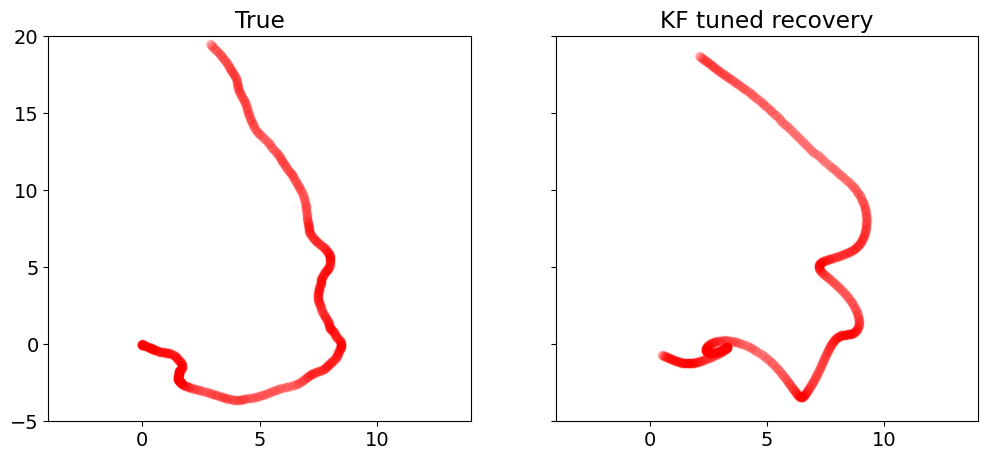

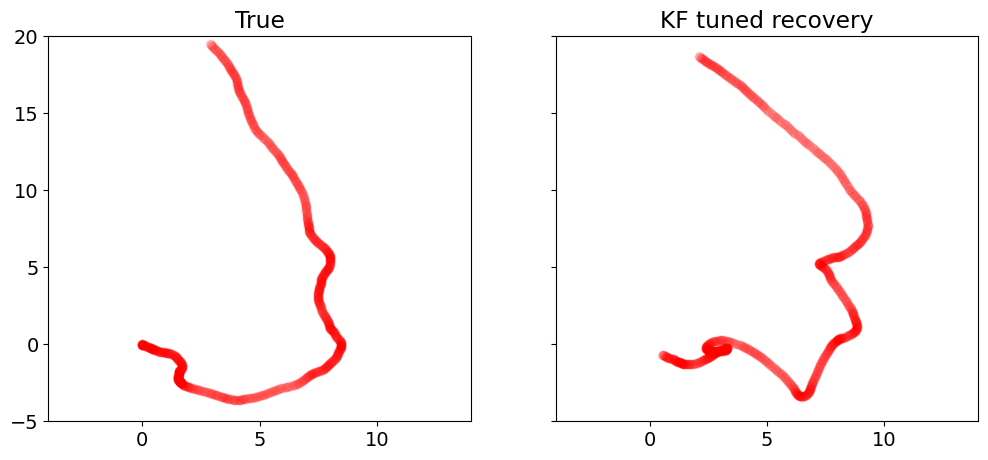

In [155]:
# plot_positions([x_true,x_hat_orig.detach().numpy()], ['True', 'KF orig. recovery'], [-4,14,-5,20])
plot_positions([x_true,x_new.detach().numpy()], ['True', 'KF tuned recovery'], [-4,14,-5,20])
plot_positions([x_true,x_hat.detach().numpy()], ['True', 'KF tuned recovery'], [-4,14,-5,20])

## Robust Smoothing

In [15]:
# initialize parameter values
# note difference between torch parameters and cvxpylayer parameters
num_train_pts, K_setminus_M = split_data(fraction=1.0)
M = ~K_setminus_M
K_setminus_M_tch, M_tch = torch.tensor(K_setminus_M), torch.tensor(M)
S, c, c_test = create_problem_data_params(K_setminus_M, num_train_pts)
S_tch = torch.tensor(S.todense(out=np.zeros((num_train_pts, N))))
c_tch, c_test_tch = torch.tensor(c), torch.tensor(c_test)

In [16]:
eta_tch = torch.tensor(0.5, requires_grad=True)
rho_tch = torch.tensor(2.0, requires_grad=True)
params = [eta_tch, rho_tch] 
robust_layer = create_robust_kalman_smoother(S, c)
x_hat_orig, w_hat_orig, v_hat_orig = robust_layer(*params)
train_loss = lambda parameters : learning_error_fn(layer=robust_layer, y=c_tch,
                                                   observable_measurements=K_setminus_M_tch,
                                                   params=parameters)
test_loss = lambda parameters : kalman_recovery_mse(y=c_test_tch, observable_measurements=M_tch,
                                                    layer=robust_layer, params=parameters)

In [17]:
batch_robust_results = robust_layer(torch.tensor([0.5, 1.0], requires_grad=True), torch.tensor([2.0, 3.0], requires_grad=True))

In [18]:
train_losses, test_losses = tune_kalman_smoother(train_loss, test_loss, params, verbose=True, print_every=5)

test loss 001 | nan


AttributeError: 'csr_matrix' object has no attribute 'A'

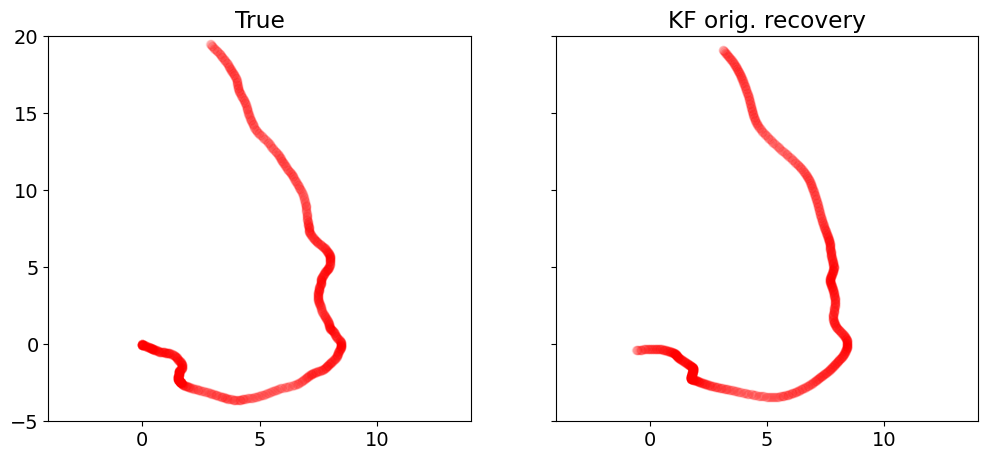

In [72]:
plot_positions([x_true,x_hat_orig.detach().numpy()], ['True', 'KF orig. recovery'], [-4,14,-5,20])
# plot_positions([x_true,x_hat.detach().numpy()], ['True', 'KF tuned recovery'], [-4,14,-5,20])

# References
- \[[BB20](https://stanford.edu/~boyd/papers/auto_ks.html)\] S. Barratt and S. Boyd. "Fitting a kalman smoother to data." 2019.
- \[[BV04](https://stanford.edu/~boyd/cvxbook/)\] S. Boyd and L. Vandenberghe. *Convex Optimization*. Cambridge University Press, 2004
- \[[BV18](https://web.stanford.edu/~boyd/vmls/)\] S. Boyd and L. Vandenberghe. *Introduction to applied linear algebra: vectors, matrices, and least squares.* Cambridge University Press, 2018.
- \[[Kal60](https://www.unitedthc.com/DSP/Kalman1960.pdf)\] R. Kalman. A new approach to linear filtering and prediction problems. *Journal Basic Engineering*, 82(1):35-45, 1960.
- \[[Mur23](https://probml.github.io/pml-book/book2.html)\] K. Murphy. *Probabilistic Machine Learning: Advanced Topics.* MIT Press, 2023.
- \[[01](https://web.stanford.edu/~boyd/papers/learning_cocps.html)\] A. Agrawal, S. Barratt, S. Boyd, and B. Stellato, "Learning convex optimization control policies," in *Proc. 2nd Annu. Conf. Learning for Dynamics and Control, 2020*
# Appendix
## Huber reformulation

(The following is a variation of \[[BV04 ex4.8](https://stanford.edu/~boyd/cvxbook/)\].)

Consider the unconstrained optimization problem

$$
\begin{equation}
\text{minimize} \; \sum_{t = 1}^{T} \phi_M(Ax_t - b_t),
\tag{A1}
\end{equation}
$$

where $x_1, \ldots, x_T \in \mathbf{R}^{n}$ are the optimization variables, and
$\phi_M : \mathbf{R}^{n} \to \mathbf{R}$ given by

$$
\phi_M(u) = \begin{cases}
\left\lVert u \right\rVert_{2}^2 & \left\lVert u \right\rVert_{2} \le M \\
M(2\left\lVert u \right\rVert_{2} - M) & \left\lVert u \right\rVert_{2} > M.
\end{cases}
$$
is the *Huber penalty function.*

The reformulation of (6) to (7) requires that we show equivalence between (A1) and

$$
\begin{equation}
\begin{array}{lll}
\text{minimize} \; & \sum_{i = 1}^{n} \left(u_t^2 + 2Mv_t \right) & \\
\text{subject to} & \left\lVert Ax_t - b_t \right\rVert_{2} \le u_t + v_t, \; & t = 1, \ldots, T \\
& 0 \preceq u \preceq M \mathbf{1} \; & \\
& v \succeq 0,
\end{array}
\tag{A2}
\end{equation}
$$
where $x_1, \ldots, x_T \in \mathbf{R}^{n}$, $u \in \mathbf{R}^{T}$,
and $v \in \mathbf{R}^{T}$ are the optimization variables.

We make the (reasonable) assumption that there exists a $t \in \left\{ 1, \ldots, T \right\}$ such that $Ax_t \not = b_t$.
Now, consider (A2) and fix $x_t$. At the optimum, it is necessary that $u_t + v_t = \left\lVert Ax_t - b_t \right\rVert_{2}$, otherwise,
since $u_t$ and $v_t$ are not simultaneously zero, we could decrease one (or both) and see a reduction in the objective function.

Therefore, we can eliminate $v_t$ from the original problem, (A2), using the substitution

$$
v_t = \left\lVert Ax_t - b_t \right\rVert_{2} - u_t,
$$

with the additional constraints

$$
u_t \le \left\lVert Ax_t - b_t \right\rVert_{2},
$$
which ensure the substition does not violate $v \succeq 0$, to form the equivalent problem

$$
\begin{array}{lll}
\text{minimize} \; & f_0(u) = \sum_{t=1}^{T} \left(u_t^2 - 2Mu_t + 2M\left\lVert Ax_t - b_t \right\rVert_{2} \right) & \\
\text{subject to} & 0 \le u_t \le \min \left\{ M, \left\lVert Ax_t - b_t \right\rVert_{2}\right\}, \quad t=1, \ldots, T. & \\
\end{array}
$$

Considering solely the objective function, a sum of (convex) quadratic functions, calculus tells us that $u_t = M$ minimizes each summand of $f_0$. However, if $\left\lVert Ax_t - b_t \right\rVert_{2} < M$ for some $t \in \left\{1, \ldots, T \right\}$, then $u_t = \left\lVert Ax_t - b_t \right\rVert_{2}$ becomes the minimizer of that particular summand. 

Therefore, when $\left\lVert Ax_t - b_t \right\rVert_{2} \le M$, we choose $u_t = \left\lVert Ax_t - b_t \right\rVert_{2}$ and the $t$ th summand simplifies to
$$
\left\lVert Ax_t - b_t \right\rVert_{2}^{2} - 2M\left\lVert Ax_t - b_t \right\rVert_{2}^{2} + 2M \left\lVert Ax_t - b_t \right\rVert_{2}^{2} = \left\lVert Ax_t - b_t \right\rVert_{2}^{2}.
$$

Otherwise, if $\left\lVert Ax_t - b_t \right\rVert_{2} > M$, we choose $u_t = M$ and the $t$ th summand becomes

$$
M^2 - 2M^2 + 2M \left\lVert Ax_t - b_t \right\rVert_{2} = M(2\left\lVert Ax_t - b_t \right\rVert_{2} - M).
$$

We conclude that for a fixed $x$, the optimal value of (A2) is given by

$$
∑_{t=1}^T ϕ_M(Ax_t - b_t).
$$

## Selection matrix construction

rows, cols = matrix.nonzero() are constructed by looping row wise through the matrix, recording the row and column value, respectively, whenever the matrix has a nonzero value

In [ ]:
cp.sum(cp.vec(y).value == c).value # check if c is ordered correctly as column majored

In [34]:
c_test = y[K_setminus_M.T]

In [36]:
nm, KM = split_data(1.0)

In [38]:
y[KM.T]

array([-1.26099346, -1.02476223, -0.18265832, ..., 18.51687772,
       19.28085045, 19.33229155])

In [39]:
y

array([[-1.26099346, -1.02476223, -0.18265832, ...,  4.69332517,
         2.68689846,  2.3267197 ],
       [ 0.13240848, -1.65302845, -1.50460709, ..., 18.51687772,
        19.28085045, 19.33229155]])

In [40]:
y.T[KM]

array([-1.26099346,  0.13240848, -1.02476223, ..., 19.28085045,
        2.3267197 , 19.33229155])